# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 30,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 1
NUM_ITER = 20
NUM_SAMPLES = 5000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [0, 1]

In [2]:
def run_outcome_regression(data):
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X']]), columns=['X', 'Y'])
    df['X'] = data['X']
    df['Y'] = data['Y']
    X_vars = df['X']
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [3]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▉                                                                                              | 99/10000 [00:43<1:13:20,  2.25it/s, train=-1.6437909712995513, val=-1.4884293797477324 (Max patience reached)]


In [4]:
gaussian_covariates_results

,ate,const,scale
0,1.050382,-0.064905,1.003842


In [5]:
display(gaussian_covariates_results.mean())
display(gaussian_covariates_results.std())

ate      1.050382
const   -0.064905
scale    1.003842
dtype: float64

ate     NaN
const   NaN
scale   NaN
dtype: float64

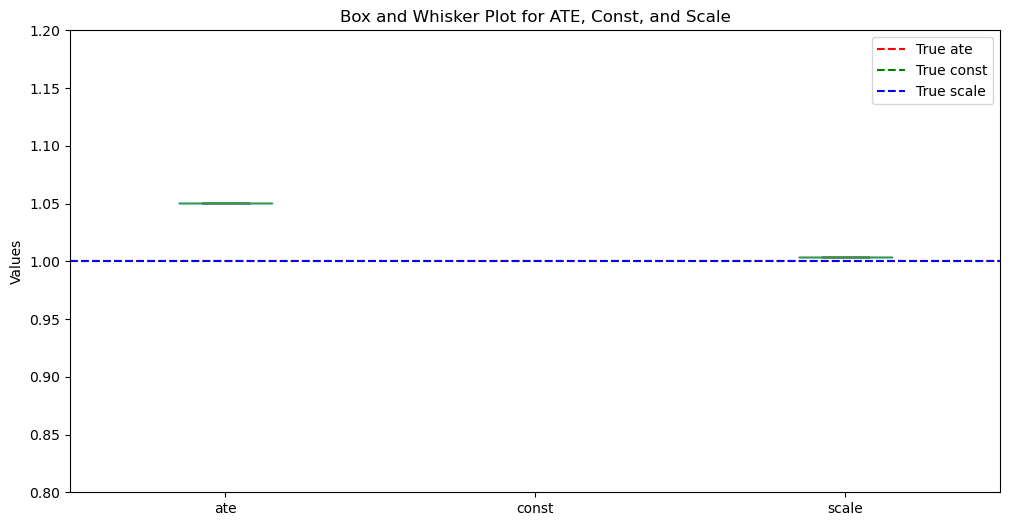

In [6]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

#### Outcome Regression

In [7]:
gaussian_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    gaussian_coeffs['ate'].append(coeff_X)
    gaussian_coeffs['const'].append(coeff_const)
gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
gaussian_outcome_coeffs

,ate,const
0,2.031925,-0.725165


In [8]:
print(gaussian_outcome_coeffs.mean())
print(gaussian_outcome_coeffs.std())

ate      2.031925
const   -0.725165
dtype: float64
ate     NaN
const   NaN
dtype: float64


### Mixed Gaussian and Gamma Outcomes

In [9]:
Z_disc, Z_cont, X, Y = causl_py.generate_mixed_samples(10000, CAUSAL_PARAMS, 0).values()

In [10]:
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

In [11]:
uz_disc_samples = uz_samples['uz_disc']
uz_cont_samples = uz_samples['uz_cont']

In [12]:
frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_cont_samples,
    condition=X,
    **hyperparams_dict,
    causal_model='gaussian',
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  1%|▋                                                                                                 | 72/10000 [00:32<1:13:53,  2.24it/s, train=1.3118372802965774, val=1.394872411050176 (Max patience reached)]


In [13]:
causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]

In [14]:
causal_margin.ate

Array(0.9003078, dtype=float64)

In [15]:
causal_margin.const

Array(0.12778634, dtype=float64)

In [16]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 1., 'const': 1., 'scale': 1}
)

  1%|▉                                                                                               | 101/10000 [00:45<1:14:44,  2.21it/s, train=1.3471179034003202, val=1.3776216603601268 (Max patience reached)]


In [17]:
continous_covariates_results

,ate,const,scale
0,0.952246,0.014496,0.99972


In [18]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      0.952246
const    0.014496
scale    0.999720
dtype: float64
ate     NaN
const   NaN
scale   NaN
dtype: float64


#### Outcome Regression

In [19]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.27695,-0.261755


In [20]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.276950
const   -0.261755
dtype: float64
ate     NaN
const   NaN
dtype: float64


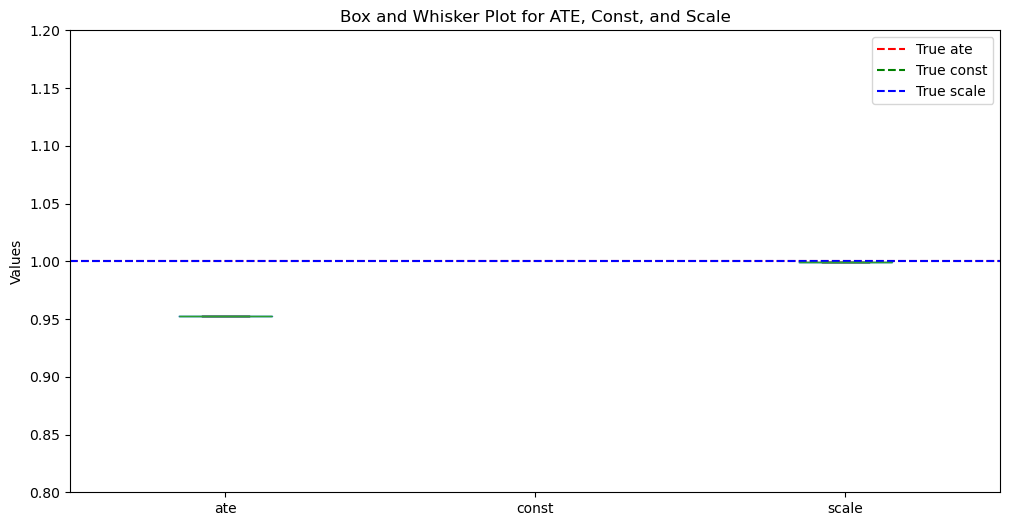

In [21]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [22]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▋                                                                                                | 68/10000 [00:31<1:16:32,  2.16it/s, train=1.3634169511079635, val=1.4078287064378716 (Max patience reached)]


In [23]:
discrete_small_covariates_results

,ate,const,scale
0,0.987726,-0.003969,0.987821


In [24]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

ate      0.987726
const   -0.003969
scale    0.987821
dtype: float64
ate     NaN
const   NaN
scale   NaN
dtype: float64


#### Outcome Regression

In [25]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.030409,-0.010012


In [26]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.030409
const   -0.010012
dtype: float64
ate     NaN
const   NaN
dtype: float64


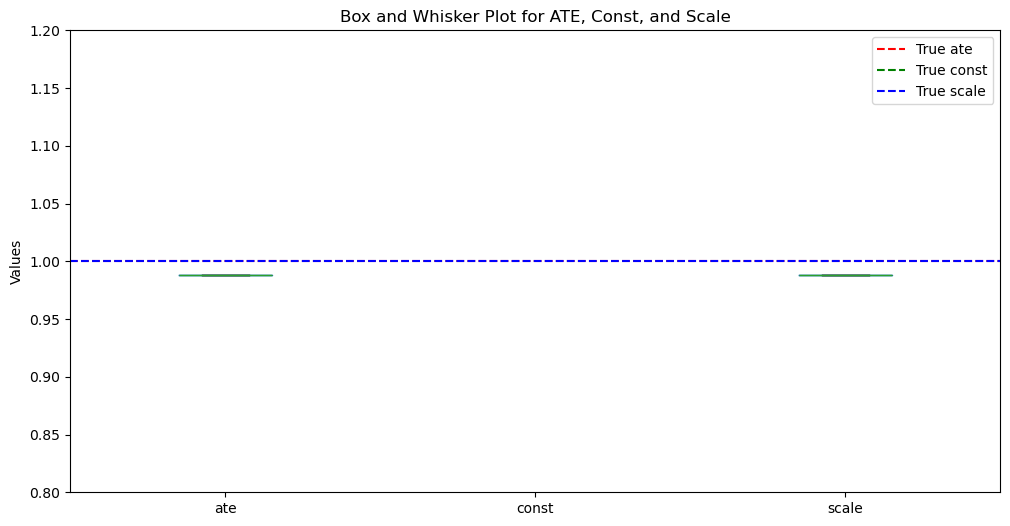

In [27]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_small_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large)

In [28]:
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▉                                                                                                | 93/10000 [01:17<2:17:00,  1.21it/s, train=0.5156906100639252, val=0.9044394889512237 (Max patience reached)]


In [29]:
discrete_big_covariates_results

,ate,const,scale
0,0.951187,0.04,1.015223


In [30]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

ate      0.951187
const    0.040000
scale    1.015223
dtype: float64
ate     NaN
const   NaN
scale   NaN
dtype: float64


#### Outcome Regression

In [31]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.927802,0.031063


In [32]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      0.927802
const    0.031063
dtype: float64
ate     NaN
const   NaN
dtype: float64


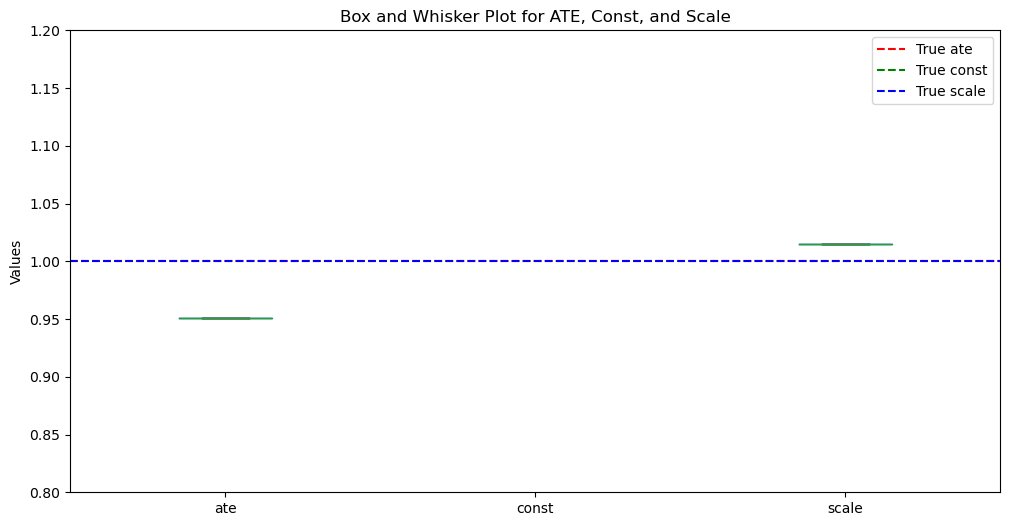

In [33]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large and Sparse)

In [ ]:
discrete_sparse_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples_sparse, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▊                                                                                                                        | 68/10000 [00:55<2:07:57,  1.29it/s, train=1.367921815013926, val=1.4896835104058426]

In [ ]:
discrete_sparse_covariates_results

In [ ]:
print(discrete_sparse_covariates_results.mean())
print(discrete_sparse_covariates_results.std())

#### Outcome Regression

In [ ]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

In [ ]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()